In [1]:
%matplotlib inline
import os
from subprocess import check_call
from glob import glob

import cftime
import xarray as xr
import numpy as np
import xesmf as xe

import woa2013

USER = os.environ['USER']

In [2]:
import importlib
importlib.reload(woa2013)

grid_src = 'RG_1x1d'
freq = 'mon'
ds1 = xr.open_dataset('/glade/work/mclong/Roemmich-Gilson-clim/RG_ArgoClim_Temperature_2017.nc',
                      decode_times = False,
                      chunks={'TIME':1})
ds2 = xr.open_dataset('/glade/work/mclong/Roemmich-Gilson-clim/RG_ArgoClim_Salinity_2017.nc',
                      decode_times = False,
                      chunks={'TIME':1})

ds = xr.merge((ds1,ds2))
ds['SALT'] = ds.ARGO_SALINITY_MEAN + ds.ARGO_SALINITY_ANOMALY
ds['TEMP'] = ds.ARGO_TEMPERATURE_MEAN + ds.ARGO_TEMPERATURE_ANOMALY

ds = ds.rename({'LATITUDE':'lat','LONGITUDE':'lon','TIME':'time'})

ds = ds.drop([v for v in ds.variables if v not in ['lat','lon','time','TEMP','SALT','PRESSURE']])
ds

<xarray.Dataset>
Dimensions:   (PRESSURE: 58, lat: 145, lon: 360, time: 156)
Coordinates:
  * lon       (lon) float32 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
  * lat       (lat) float32 -64.5 -63.5 -62.5 -61.5 ... 76.5 77.5 78.5 79.5
  * PRESSURE  (PRESSURE) float32 2.5 10.0 20.0 30.0 ... 1800.0 1900.0 1975.0
  * time      (time) float32 0.5 1.5 2.5 3.5 4.5 ... 152.5 153.5 154.5 155.5
Data variables:
    SALT      (PRESSURE, lat, lon, time) float32 dask.array<shape=(58, 145, 360, 156), chunksize=(58, 145, 360, 1)>
    TEMP      (PRESSURE, lat, lon, time) float32 dask.array<shape=(58, 145, 360, 156), chunksize=(58, 145, 360, 1)>

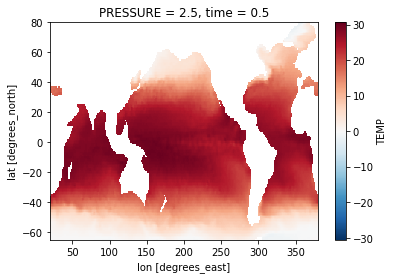

In [3]:
ds.TEMP.isel(PRESSURE=0,time=0).plot()

In [4]:
print(ds.time.attrs)
print(len(ds.time)/12)
nyear = int(len(ds.time)/12)
from itertools import product

dpm = np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.])
dates = [cftime.datetime(year, month, 1) for year, month in
             product(range(2004, 2004+nyear), range(1, 13))]


time_bound = [[0,dpm[month-1]] for year, month in
             product(range(2004, 2004+nyear), range(1, 13))]

ds['time_bound'] = xr.DataArray(time_bound,dims=('time','d2'))
ds.time.values = xr.CFTimeIndex(dates)
ds.time.attrs['calendar'] = 'standard'
ds

OrderedDict([('units', 'months since 2004-01-01 00:00:00'), ('time_origin', '01-JAN-2004 00:00:00'), ('axis', 'T')])
13.0


<xarray.Dataset>
Dimensions:     (PRESSURE: 58, d2: 2, lat: 145, lon: 360, time: 156)
Coordinates:
  * time        (time) object 2004-01-01 00:00:00 ... 2016-12-01 00:00:00
  * lon         (lon) float32 20.5 21.5 22.5 23.5 ... 376.5 377.5 378.5 379.5
  * lat         (lat) float32 -64.5 -63.5 -62.5 -61.5 ... 76.5 77.5 78.5 79.5
  * PRESSURE    (PRESSURE) float32 2.5 10.0 20.0 30.0 ... 1800.0 1900.0 1975.0
Dimensions without coordinates: d2
Data variables:
    SALT        (PRESSURE, lat, lon, time) float32 dask.array<shape=(58, 145, 360, 156), chunksize=(58, 145, 360, 1)>
    TEMP        (PRESSURE, lat, lon, time) float32 dask.array<shape=(58, 145, 360, 156), chunksize=(58, 145, 360, 1)>
    time_bound  (time, d2) float64 0.0 31.0 0.0 28.0 0.0 ... 0.0 30.0 0.0 31.0

In [5]:
import calc
dsm = calc.compute_mon_climatology(ds)
dsm

<xarray.Dataset>
Dimensions:       (PRESSURE: 58, d2: 2, lat: 145, lon: 360, time: 12)
Coordinates:
  * PRESSURE      (PRESSURE) float64 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
  * lat           (lat) float64 -64.5 -63.5 -62.5 -61.5 ... 76.5 77.5 78.5 79.5
  * lon           (lon) float64 20.5 21.5 22.5 23.5 ... 376.5 377.5 378.5 379.5
  * time          (time) float64 15.5 14.0 15.5 15.0 ... 15.0 15.5 15.0 15.5
Dimensions without coordinates: d2
Data variables:
    SALT          (time, PRESSURE, lat, lon) float32 dask.array<shape=(12, 58, 145, 360), chunksize=(1, 58, 145, 360)>
    TEMP          (time, PRESSURE, lat, lon) float32 dask.array<shape=(12, 58, 145, 360), chunksize=(1, 58, 145, 360)>
    month         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
    month_bounds  (time, d2) float64 0.0 31.0 0.0 28.0 0.0 ... 0.0 30.0 0.0 31.0

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


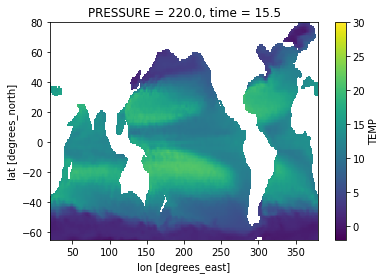

In [10]:
dsm.TEMP.isel(time=0,PRESSURE=20).plot(vmin=-2,vmax=30)

In [11]:
dsm = dsm.compute()

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [12]:
def compute_kmt(ds,varname):
    '''Compute an KMT-like index'''
    nk = ds[varname].shape[1]
    #-- init KMT array
    KMT = np.zeros(ds[varname].shape[-2:]).astype(int)

    #-- where surface is missing, KMT = 0, else full depth
    KMT = np.where(np.isnan(ds[varname].values[0,0,:,:]),0,nk)

    #-- loop over k
    #   where level k is missing: KMT = k, i.e. the level above in 1-based indexing
    for k in range(1,nk):
        KMT = np.where(np.isnan(ds[varname].values[0,k,:,:]) & (KMT > k),k,KMT)

    return KMT

def derive_var_MLD(ds, Dsigma=0.03):
    '''Return the mixed layer depth computed from potential density criterion.
    '''
    import popeos

    attrs = ds.TEMP.attrs.copy()
    encoding = ds.TEMP.encoding

    RHO = popeos.eos(SALT=ds.SALT,TEMP=ds.TEMP,DEPTH=0.,PRESS_IN=False)
    RHO = RHO - 1000.

    KMT = compute_kmt(ds,'TEMP').astype(int)
    z_t = ds.PRESSURE

    nl, nk, nj, ni = ds.TEMP.shape
    MLD = np.ones((nl, nj, ni)) * np.nan

    for j in range(0,nj):
        for i in range(0,ni):
            kmt = KMT[j,i]
            if kmt == 0: continue
            for l in range(0,nl):
                rho = RHO[l,0:kmt,j,i]
                z = z_t[0:kmt]

                rho, I = np.unique(rho, return_index=True)
                z = z[I]
                if len(I) >= 3:
                    MLD[l,j,i] = np.interp(rho[0]+Dsigma, rho, z)

    ds = ds.drop(['TEMP','SALT'])
    ds = ds.load()
    ds['MLD'] = xr.DataArray(MLD,
                             dims=('time','nlat','nlon'),
                             coords={'time':ds.time},
                             attrs=attrs,
                             encoding=encoding)

    ds.MLD.attrs['long_name'] = 'MLD'
    ds.MLD.attrs['definition'] = f'$\Delta\sigma = {Dsigma:0.3f}$'
    ds.MLD.attrs['units'] = 'm'

    return ds

In [13]:
dsmld = derive_var_MLD(dsm)
dsmld

<xarray.Dataset>
Dimensions:       (PRESSURE: 58, d2: 2, lat: 145, lon: 360, nlat: 145, nlon: 360, time: 12)
Coordinates:
  * PRESSURE      (PRESSURE) float64 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
  * lat           (lat) float64 -64.5 -63.5 -62.5 -61.5 ... 76.5 77.5 78.5 79.5
  * lon           (lon) float64 20.5 21.5 22.5 23.5 ... 376.5 377.5 378.5 379.5
  * time          (time) float64 15.5 14.0 15.5 15.0 ... 15.0 15.5 15.0 15.5
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    month         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
    month_bounds  (time, d2) float64 0.0 31.0 0.0 28.0 0.0 ... 0.0 30.0 0.0 31.0
    MLD           (time, nlat, nlon) float64 12.56 12.17 11.93 ... nan nan nan

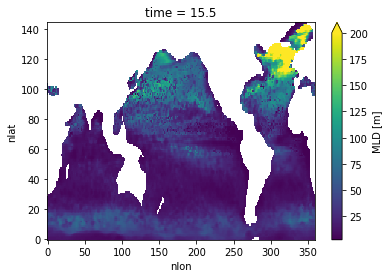

In [15]:
dsmld.MLD.isel(time=0).plot(vmax=200.)

In [18]:
weight_file_dir = f'/glade/work/mclong/regrid_xesmf/weight_files'
if not os.path.exists(weight_file_dir):
    check_call(['mkdir','-p',weight_file_dir])
   

method = 'bilinear'
variable = 'MLD'

for grid_dst in ['POP_gx1v6','POP_gx1v7']:
    
    diro = f'/glade/work/mclong/woa2013v2/derived/{grid_dst}'
    if not os.path.exists(diro):
        check_call(['mkdir','-p',diro])
        
    grid_sname = grid_dst.replace('POP_','')
    file_out = f'{diro}/mld_{freq}_{grid_src}_to_{grid_sname}.nc'

    if os.path.exists(file_out): 
        print(f'exists {file_out}')
        continue
    
    grid_file = f'/glade/work/mclong/grids/{grid_dst}.nc'
    dsg = xr.open_dataset(grid_file,decode_times=False,decode_coords=False)
    dsg.rename({'TLONG': 'lon', 'TLAT': 'lat'}, inplace=True)
    
    weight_file = f'{weight_file_dir}/{method}_{grid_src}_to_{grid_dst}.nc'

    regridder = xe.Regridder(dsmld.drop([v for v in dsmld.variables if v not in ['lat','lon']]),
                             dsg,
                             method=method,
                             filename=weight_file,
                             periodic=True,
                             reuse_weights=True)
    
    dsg.rename({'lon':'TLONG', 'lat': 'TLAT'}, inplace=True)
    
    dso = xr.Dataset()
    dso[variable] = regridder(dsmld[variable])
    dso = dso.drop(['lat','lon'])
    for gvar in dsg.variables:
        dso[gvar] = dsg[gvar]

    print(f'writing {file_out}')
    dso.to_netcdf(file_out)
        
dso

Reuse existing file: /glade/work/mclong/regrid_xesmf/weight_files/bilinear_RG_1x1d_to_POP_gx1v6.nc
writing /glade/work/mclong/woa2013v2/derived/POP_gx1v6/mld_mon_RG_1x1d_to_gx1v6.nc
Create weight file: /glade/work/mclong/regrid_xesmf/weight_files/bilinear_RG_1x1d_to_POP_gx1v7.nc
writing /glade/work/mclong/woa2013v2/derived/POP_gx1v7/mld_mon_RG_1x1d_to_gx1v7.nc


<xarray.Dataset>
Dimensions:               (lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 12, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * time                  (time) float64 15.5 14.0 15.5 15.0 ... 15.5 15.0 15.5
  * z_t                   (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
  * z_w                   (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                 (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
  * z_t_150m              (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w_bot               (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * z_w_top               (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
Dimensions without coordinates: moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables:
    MLD                   (time, nlat, nlon) float64 

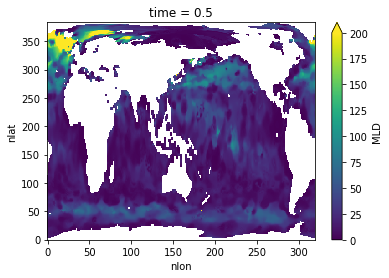

In [6]:
dso.MLD.isel(time=0).plot(vmin=0,vmax=200)